In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

%matplotlib inline 

In [2]:
pd.set_option('display.max_rows', 100)

## Load Data

In [121]:
aisles = pd.read_csv('data/aisles.csv', dtype = {
    'aisle_id': np.uint16,
    'aisle': np.str},
    usecols=['aisle_id', 'aisle'])

In [122]:
departments = pd.read_csv('data/departments.csv', dtype = {
    'department_id': np.uint16,
    'department': np.str},
    usecols=['department_id', 'department'])

In [123]:
order_products_prior = pd.read_csv('data/order_products__prior.csv', dtype = {
    'order_id': np.uint32,
    'product_id': np.uint32,
    'add_to_cart_order': np.uint16,
    'reordered': np.uint16},
    usecols=['order_id', 'product_id', 'add_to_cart_order', 'reordered'])

In [124]:
order_product_train = pd.read_csv('data/order_products__train.csv', dtype = {
    'order_id': np.uint32,
    'product_id': np.uint32,
    'add_to_cart_order': np.uint16,
    'reordered': np.uint16},
    usecols=['order_id', 'product_id', 'add_to_cart_order', 'reordered'])

In [118]:
orders = pd.read_csv('data/orders.csv', dtype = {
    'order_id': np.uint32,
    'user_id' :np.uint32,
    'eval_set': 'category',
    'order_number': np.uint16,
    'order_dow': np.uint16,
    'order_hour_of_day': np.uint8,
    'days_since_prior_order': np.float32},
                     usecols=['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'])

In [125]:
products = pd.read_csv('data/products.csv', dtype = {'product_id': np.uint16,
        'product_name': np.str,
        'aisle_id': np.uint16,
        'department_id': np.uint16},
        usecols=['product_id', 'product_name', 'aisle_id', 'department_id'])

##  Genarating Features

In [18]:
orders['days_since_first_order'] = orders.groupby('user_id')['days_since_prior_order'].cumsum()

In [23]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order
0,2539329,1,prior,1,2,8,NaN,NaN
1,2398795,1,prior,2,3,7,15.0,15.0
2,473747,1,prior,3,3,12,21.0,36.0
3,2254736,1,prior,4,4,7,29.0,65.0
4,431534,1,prior,5,4,15,28.0,93.0


In [19]:
order_products_prior.shape

(32434489, 4)

In [20]:
priordf = pd.merge(order_products_prior, orders, on = 'order_id', how = 'left')

In [21]:
priordf.shape

(32434489, 11)

In [22]:
priordf.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order
0,2,33120,1,1,202279,prior,3,5,9,8.0,28.0
1,2,28985,2,1,202279,prior,3,5,9,8.0,28.0
2,2,9327,3,0,202279,prior,3,5,9,8.0,28.0
3,2,45918,4,1,202279,prior,3,5,9,8.0,28.0
4,2,30035,5,0,202279,prior,3,5,9,8.0,28.0


In [24]:
priordf['days_since_first_order'].fillna(0, inplace=True)

In [25]:
priordf.sort_values(['user_id', 'product_id','order_number'], inplace = True)

In [27]:
priordf['days_since_prior_product_purchase'] = priordf.groupby(['user_id', 'product_id'])['days_since_first_order'].transform(lambda x: x.diff())

In [29]:
#pickle.dump(priordf, open('data/priordf.p', 'wb'))

In [ ]:
#priordf = pickle.load(open('data/priordf.p', 'rb'))

In [126]:
user_info = pd.DataFrame()
user_info['user_count_of_order'] = priordf.groupby('user_id')['order_id'].nunique().astype(np.uint16)

In [127]:
user_info['user_average_order_interval'] = pd.DataFrame(priordf.groupby(['user_id', 'order_id'])['days_since_prior_order'].mean()).groupby(['user_id'])['days_since_prior_order'].mean().astype(np.float32)

In [128]:
user_info['user_average_basket_size'] = pd.DataFrame(priordf.groupby(['user_id', 'order_id'])['product_id'].count()).groupby('user_id')['product_id'].mean().astype(np.float32)

In [129]:
user_info.head()

,user_count_of_order,user_average_order_interval,user_average_basket_size
user_id,,,
1,10,19.555555,5.900000
2,14,15.230769,13.928572
3,12,12.090909,7.333333
4,5,13.750000,3.600000
5,4,13.333333,9.250000


In [130]:
product_info = pd.DataFrame()

In [131]:
product_info['product_user_count'] = priordf.groupby(['product_id'])['user_id'].nunique().astype(np.uint32)

In [132]:
product_info['product_order_count'] = priordf.groupby(['product_id'])['order_id'].nunique().astype(np.uint32)

In [133]:
product_info['product_average_purchase_interval'] = priordf.groupby(['product_id'])['days_since_prior_product_purchase'].mean().astype(np.float32)

In [134]:
product_info['product_reorder_count'] = priordf[priordf.reordered == 1].groupby(['product_id'])['order_id'].nunique().astype(np.uint32)

In [135]:
product_info['reorder_ratio'] = product_info['product_reorder_count']/product_info['product_order_count']

In [136]:
product_info.head()

,product_user_count,product_order_count,product_average_purchase_interval,product_reorder_count,reorder_ratio
product_id,,,,,
1,716,1852,27.961267,1136.0,0.613391
2,78,90,50.166668,12.0,0.133333
3,74,277,19.369457,203.0,0.732852
4,182,329,31.707483,147.0,0.446809
5,6,15,34.888889,9.0,0.600000


In [137]:
user_product_info = pd.DataFrame(priordf.reset_index().groupby(['user_id', 'product_id'])['order_id'].nunique())

In [138]:
user_product_info.rename(columns = {'order_id': 'user_product_purchase_count'}, inplace = True)

In [139]:
user_product_info['user_product_last_purchase_day'] = priordf.reset_index().groupby(['user_id', 'product_id'])['days_since_first_order'].max().astype(np.uint32)

In [143]:
user_product_info['user_product_average_purchase_interval'] = priordf.reset_index().groupby(['user_id', 'product_id'])['days_since_prior_product_purchase'].mean()

In [148]:
masterdf = pd.merge(user_product_info.reset_index(), user_info.reset_index(), on='user_id', how='left')

In [149]:
masterdf = pd.merge(masterdf, product_info.reset_index(), on='product_id', how = 'left')

In [151]:
masterdf.head()

,user_id,product_id,user_product_purchase_count,user_product_last_purchase_day,user_product_average_purchase_interval,user_count_of_order,user_average_order_interval,user_average_basket_size,product_user_count,product_order_count,product_average_purchase_interval,product_reorder_count,reorder_ratio
0,1,196,10,176,19.555555,10,19.555555,5.9,8000,35791,22.623835,27791.0,0.776480
1,1,10258,9,176,20.125000,10,19.555555,5.9,557,1946,24.268539,1389.0,0.713772
2,1,10326,1,93,NaN,10,19.555555,5.9,1923,5526,26.605606,3603.0,0.652009
3,1,12427,10,176,19.555555,10,19.555555,5.9,1679,6476,19.953512,4797.0,0.740735
4,1,13032,3,176,80.500000,10,19.555555,5.9,1286,3751,31.215416,2465.0,0.657158


In [175]:
#pickle.dump(masterdf, open('data/masterdf.p', 'wb'))

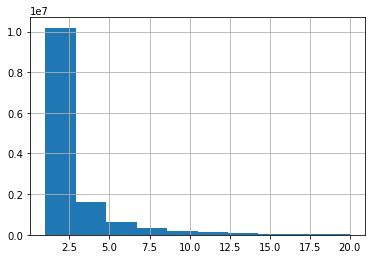

In [161]:
masterdf[masterdf.user_product_purchase_count <= 20].user_product_purchase_count.hist(bins = 10);

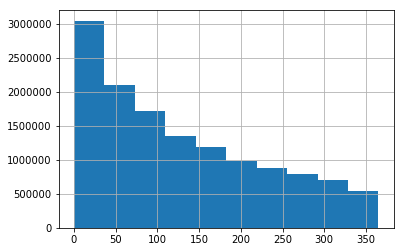

In [163]:
masterdf.user_product_last_purchase_day.hist();

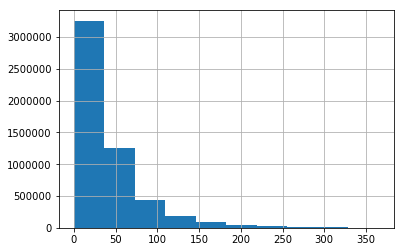

In [165]:
masterdf.user_product_average_purchase_interval.hist();

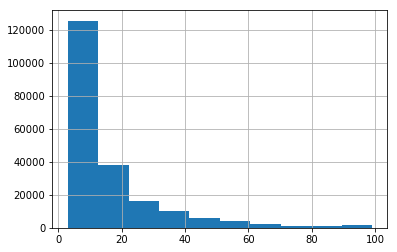

In [168]:
user_info['user_count_of_order'].hist();

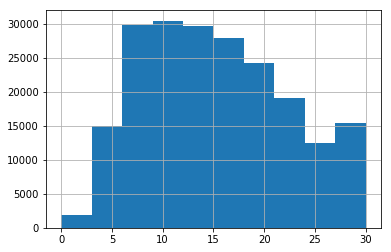

In [169]:
user_info.user_average_order_interval.hist();

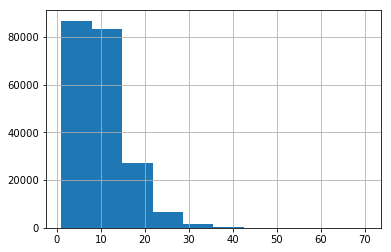

In [170]:
user_info.user_average_basket_size.hist();

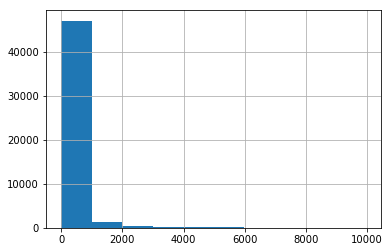

In [172]:
product_info[product_info.product_user_count < 10000].product_user_count.hist();

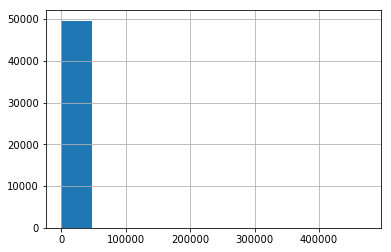

In [174]:
product_info.product_order_count.hist();

## Baseline

In [176]:
train_users = orders[orders.eval_set == 'train'].user_id

In [189]:
train_users.head()

10    1
25    2
49    5
74    7
78    8
Name: user_id, dtype: uint32

In [181]:
traindf = masterdf[masterdf.user_id.isin(train_users)]

In [191]:
traindf = pd.merge(traindf, orders[orders.eval_set == 'train'], on='user_id', how = 'left')

In [195]:
traindf = pd.merge(traindf, order_product_train, on =['order_id', 'product_id'], how = 'left')

In [197]:
traindf.columns

Index(['user_id', 'product_id', 'user_product_purchase_count',
       'user_product_last_purchase_day',
       'user_product_average_purchase_interval', 'user_count_of_order',
       'user_average_order_interval', 'user_average_basket_size',
       'product_user_count', 'product_order_count',
       'product_average_purchase_interval', 'product_reorder_count',
       'reorder_ratio', 'order_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order',
       'reordered'],
      dtype='object')

In [199]:
traindf.reordered.fillna(0, inplace = True)

In [200]:
traindf.reordered.value_counts()

0.0    7645837
1.0     828824
Name: reordered, dtype: int64

In [203]:
traindf.rename(columns = {'reordered': 'y'}, inplace = True)

In [205]:
traindf.columns

Index(['user_id', 'product_id', 'user_product_purchase_count',
       'user_product_last_purchase_day',
       'user_product_average_purchase_interval', 'user_count_of_order',
       'user_average_order_interval', 'user_average_basket_size',
       'product_user_count', 'product_order_count',
       'product_average_purchase_interval', 'product_reorder_count',
       'reorder_ratio', 'order_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order',
       'y'],
      dtype='object')

In [206]:
traindf['user_product_rank'] = traindf.groupby('user_id')['user_product_purchase_count'].rank(ascending=False)

In [208]:
traindf.head()

,user_id,product_id,user_product_purchase_count,user_product_last_purchase_day,user_product_average_purchase_interval,user_count_of_order,user_average_order_interval,user_average_basket_size,product_user_count,product_order_count,...,reorder_ratio,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,y,user_product_rank
0,1,196,10,176,19.555555,10,19.555555,5.9,8000,35791,...,0.776480,1187899,train,11,4,8,14.0,1.0,1.0,1.5
1,1,10258,9,176,20.125000,10,19.555555,5.9,557,1946,...,0.713772,1187899,train,11,4,8,14.0,6.0,1.0,3.0
2,1,10326,1,93,NaN,10,19.555555,5.9,1923,5526,...,0.652009,1187899,train,11,4,8,14.0,NaN,0.0,14.5
3,1,12427,10,176,19.555555,10,19.555555,5.9,1679,6476,...,0.740735,1187899,train,11,4,8,14.0,NaN,0.0,1.5
4,1,13032,3,176,80.500000,10,19.555555,5.9,1286,3751,...,0.657158,1187899,train,11,4,8,14.0,7.0,1.0,5.5


In [212]:
traindf['y_predicted'] = np.where(traindf.user_product_rank < traindf.user_average_basket_size, 1, 0)

In [214]:
traindf.head()

,user_id,product_id,user_product_purchase_count,user_product_last_purchase_day,user_product_average_purchase_interval,user_count_of_order,user_average_order_interval,user_average_basket_size,product_user_count,product_order_count,...,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,y,user_product_rank,y_predicted
0,1,196,10,176,19.555555,10,19.555555,5.9,8000,35791,...,1187899,train,11,4,8,14.0,1.0,1.0,1.5,1
1,1,10258,9,176,20.125000,10,19.555555,5.9,557,1946,...,1187899,train,11,4,8,14.0,6.0,1.0,3.0,1
2,1,10326,1,93,NaN,10,19.555555,5.9,1923,5526,...,1187899,train,11,4,8,14.0,NaN,0.0,14.5,0
3,1,12427,10,176,19.555555,10,19.555555,5.9,1679,6476,...,1187899,train,11,4,8,14.0,NaN,0.0,1.5,1
4,1,13032,3,176,80.500000,10,19.555555,5.9,1286,3751,...,1187899,train,11,4,8,14.0,7.0,1.0,5.5,1


In [215]:
from sklearn.metrics import f1_score

In [216]:
f1_score(traindf.y, traindf.y_predicted)

0.37379894766909949

## Models!